In [ ]:
# Author: Kerem Kazan
# Title: Chess Commentator Transformer - Data Quality

# Visualization

In [8]:
# In this notebook, we will dig a bit deeper into our data and inspect its quality. Let's load the dataset first:

ANNOTATED_POSITIONS_OUTPUT_CSV = "../dataset/data/gameknot_annotated_positions.csv"

In [9]:
import pandas as pd

df = pd.read_csv(ANNOTATED_POSITIONS_OUTPUT_CSV)

test_move = df.iloc[304]

test_move

fen_before          r3kb1r/2q2ppp/p1p1p3/2PpPn2/1P6/2P1BQ1P/P4PP1/...
fen_after           r3kb1r/5ppp/p1p1p3/2Ppqn2/1P6/2P1BQ1P/P4PP1/RN...
uci                                                              c7e5
comment             Picking up the free pawn. Now material is even...
full_move_number                                                   14
is_white                                                        False
game                             ./dataset/data/gameknot/pgn/6562.pgn
Name: 304, dtype: object

In [10]:
# We will now create a convenience visualization function to display a single row from the dataset.

# Let's create a helper visualization function that will let us inspect the data.

import chess
import chess.svg
from IPython.display import display, HTML

def display_data_item(data_item):
  board_before = chess.Board(data_item['fen_before'])
  move = chess.Move.from_uci(data_item['uci'])
  turn = "White" if data_item['is_white'] else "Black"
  size=390

  svg = chess.svg.board(
    board_before,
    arrows=[chess.svg.Arrow(move.from_square, move.to_square)],
    size=size
  )

  # Create HTML to display boards side by side
  html = f"""
  <div>
    <table>
      <tr>
        <td>Move</td>
        <td>{data_item['uci']}</td>
      </tr>
      <tr>
        <td>Move #</td>
        <td>{data_item['full_move_number']}</td>
      </tr>
      <tr>
        <td>Turn</td>
        <td>{turn}</td>
      </tr>
      <tr>
        <td>Comment</td>
        <td>{data_item['comment']}</td>
      </tr>
    </table>
    <div style="display: flex; gap: 20px;">
      <svg width="{size}" height="{size}">{svg}</svg>
    </div>
  </div>
  """
  display(HTML(html))


In [11]:
# Let's try it:

display_data_item(test_move)

Move,c7e5
Move #,14
Turn,Black
Comment,"Picking up the free pawn. Now material is even, but Black has the better position due to the weak White queenside pawns, and better pieces. Note that the Nb1 can't move because the c3 pawn will hang."


# Comment Analysis

In [12]:
# Let's use tiktoken to count the tokens in the comments:
import tiktoken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Initialize the tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

# First, a quick check:

comment_example = test_move['comment']
encoded_input = tokenizer.encode(comment_example)
print(f"Example comment: {comment_example}")
print(f"Encoded comment: {encoded_input}")
print(f"Number of tokens: {len(encoded_input)}")
decoded = tokenizer.decode(encoded_input)
print(f"Decoded comment: {decoded}")


Example comment: Picking up the free pawn. Now material is even, but Black has the better position due to the weak White queenside pawns, and better pieces. Note that the Nb1 can't move because the c3 pawn will hang.
Encoded comment: [47, 7958, 510, 262, 1479, 29649, 13, 2735, 2587, 318, 772, 11, 475, 2619, 468, 262, 1365, 2292, 2233, 284, 262, 4939, 2635, 38771, 485, 29649, 82, 11, 290, 1365, 5207, 13, 5740, 326, 262, 399, 65, 16, 460, 470, 1445, 780, 262, 269, 18, 29649, 481, 8181, 13]
Number of tokens: 49
Decoded comment: Picking up the free pawn. Now material is even, but Black has the better position due to the weak White queenside pawns, and better pieces. Note that the Nb1 can't move because the c3 pawn will hang.


In [13]:
# Before we attempt training, let's analyze the comments dataset.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_token_length_stats(token_lengths):
  # Compute stats
  median_len = int(token_lengths.median())
  std_dev = int(token_lengths.std())
  p90 = int(np.percentile(token_lengths, 90))
  p95 = int(np.percentile(token_lengths, 95))
  p99 = int(np.percentile(token_lengths, 99))
  max_len = int(token_lengths.max())

  print(f"Median token length: {median_len:.2f}")
  print(f"Standard deviation: {std_dev:.2f}")
  print(f"90th percentile: {p90}")
  print(f"95th percentile: {p95}")
  print(f"99th percentile: {p99}")
  print(f"Max token length: {max_len}")

  # Plot distribution
  plt.hist(token_lengths, bins=40)

  plt.axvline(median_len, color='yellow', linestyle='--', label=f'Median = {median_len}')
  plt.axvline(p90, color='green', linestyle='--', label=f'90th percentile = {p90}')
  plt.axvline(p95, color='blue', linestyle='--', label=f'95th percentile = {p95}')
  plt.axvline(p99, color='red', linestyle='--', label=f'99th percentile = {p99}')

  plt.title("Token Length Distribution")
  plt.xlabel("Tokens per comment")
  plt.ylabel("Frequency")
  plt.legend()

Median token length: 18.00
Standard deviation: 31.00
90th percentile: 58
95th percentile: 80
99th percentile: 151
Max token length: 1284


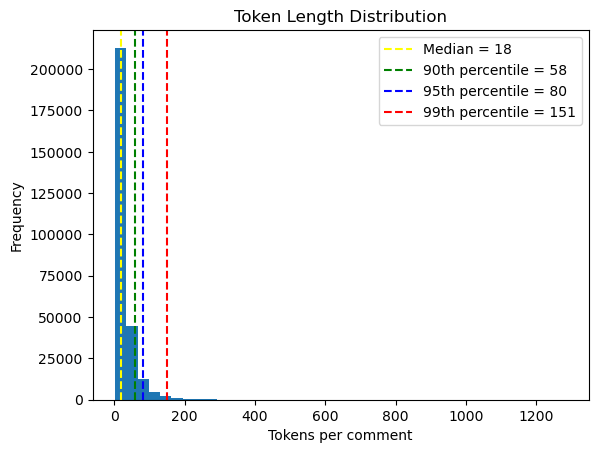

In [14]:
# Tokenize and get lengths
token_lengths = df['comment'].apply(lambda comment: len(tokenizer.encode(comment)))
get_token_length_stats(token_lengths)

In [16]:
# As expected, an extremely right skewed distribution. Let's cutoff the 99th percentile.

def find_truncation_length(token_lengths, percentile=95, base=8):
    """
    Finds the smallest multiple of `base` that fits the desired percentile of token lengths.

    Args:
        token_lengths (list or np.array or pd.Series): List of tokenized sequence lengths.
        percentile (int): Percentile to cover (default is 95).
        base (int): Alignment base (e.g., 8, 16, 32, 64). Default is 8.

    Returns:
        int: Suggested truncation length.
    """
    assert 0 < percentile <= 100, "Percentile must be in (0, 100]"
    token_lengths = np.asarray(token_lengths)
    p_value = np.percentile(token_lengths, percentile)
    truncation_length = int(np.ceil(p_value / base) * base)
    return truncation_length

truncation_len = find_truncation_length(token_lengths, 99, base=8)
print("Suggested truncation length: ", truncation_len)

Suggested truncation length:  152


In [17]:
def encode_and_truncate(tokenizer, comment, max_length):
    encoded = tokenizer.encode(comment)
    truncated = encoded[:max_length]
    return truncated

Median token length: 18.00
Standard deviation: 26.00
90th percentile: 57
95th percentile: 80
99th percentile: 150
Max token length: 152


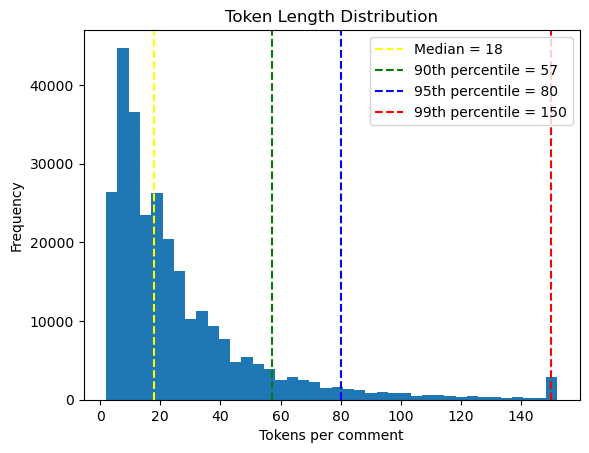

In [18]:
# Load comments

# Tokenize and get lengths
game_lengths = df['comment'].apply(lambda comment: len(encode_and_truncate(
  tokenizer=tokenizer, 
  comment=comment.lower(), 
  max_length=truncation_len))
)
get_token_length_stats(game_lengths)

# Game Length Distribution

In [23]:
# Now let us switch our attention to game lengths. Games will have variance in terms of the number of moves, and we need to account for this.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_full_move_number_stats(game_lengths):
  # Compute stats
  median_len = int(game_lengths.median())
  std_dev = int(game_lengths.std())
  p90 = int(np.percentile(game_lengths, 90))
  p95 = int(np.percentile(game_lengths, 95))
  p99 = int(np.percentile(game_lengths, 99))
  # max_len = int(game_lengths.max())

  print(f"Median game length: {median_len:.2f}")
  print(f"Standard deviation: {std_dev:.2f}")
  print(f"90th percentile: {p90}")
  print(f"95th percentile: {p95}")
  print(f"99th percentile: {p99}")
  # print(f"Max token length: {max_len}")

  # Plot distribution
  plt.hist(game_lengths, bins=40)

  plt.axvline(median_len, color='yellow', linestyle='--', label=f'Median = {median_len}')
  plt.axvline(p90, color='green', linestyle='--', label=f'90th percentile = {p90}')
  plt.axvline(p95, color='blue', linestyle='--', label=f'95th percentile = {p95}')
  plt.axvline(p99, color='red', linestyle='--', label=f'99th percentile = {p99}')

  plt.title("Full Move # Distribution")
  plt.xlabel("Full Move #")
  plt.ylabel("Frequency")
  plt.legend()

Median game length: 17.00
Standard deviation: 13.00
90th percentile: 37
95th percentile: 44
99th percentile: 61


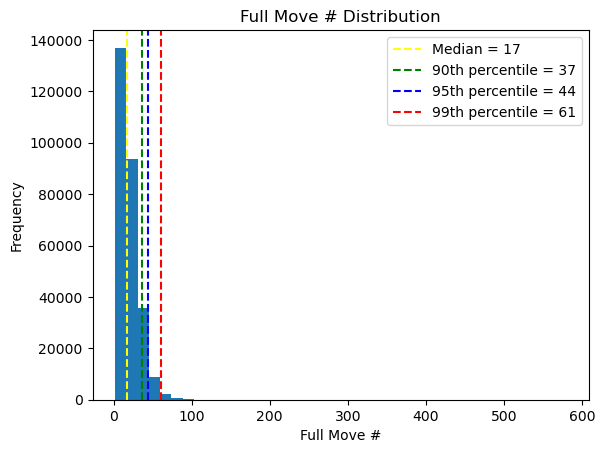

In [24]:
game_lengths = df["full_move_number"]
get_full_move_number_stats(game_lengths)

In [25]:
import numpy as np

# Once again as expected, it's an extremely right skewed distribution. Let's cutoff at 99th percentile.

full_move_number_cutoff = int(np.percentile(game_lengths, 99))
print("Cutoff: ", full_move_number_cutoff)

# Filter out the data frames with game lengths greater than the cutoff:

# Load games
new_df = df[df["full_move_number"] <= full_move_number_cutoff]

print(f"Pre-filter: {len(df)}")
print(f"Post-filter: {len(new_df)}")
print(f"Removed: {len(df) - len(new_df)}")

# Save the filtered data:

FILTERED_ANNOTATED_POSITIONS_OUTPUT_CSV = "./dataset/data/gameknot_annotated_positions_filtered.csv"

new_df.to_csv(FILTERED_ANNOTATED_POSITIONS_OUTPUT_CSV, index=False)

Cutoff:  61
Pre-filter: 278530
Post-filter: 275958
Removed: 2572


Median game length: 17.00
Standard deviation: 12.00
90th percentile: 36
95th percentile: 42
99th percentile: 54


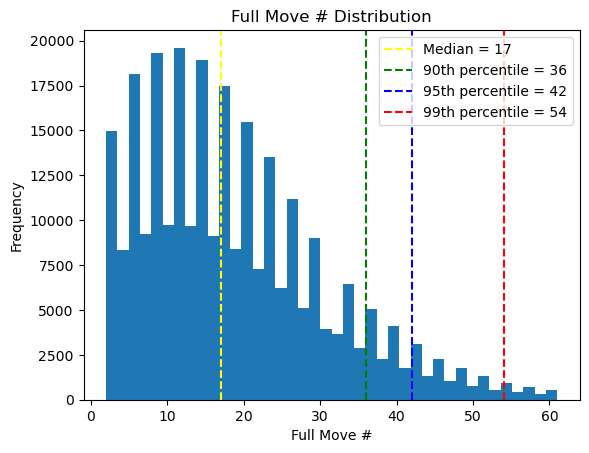

In [26]:
game_lengths = new_df["full_move_number"]
get_full_move_number_stats(game_lengths)

In [ ]:
# We now see a pretty interesting aspect of our dataset. This is almost like a bell curve, but with an intense editorial bias. Certain moves are much likelier to get comments, which show up in these spikes in the dataset.

In [ ]:
# We are now done with the data quality checks. Let's move on to the next step: Tokenization.